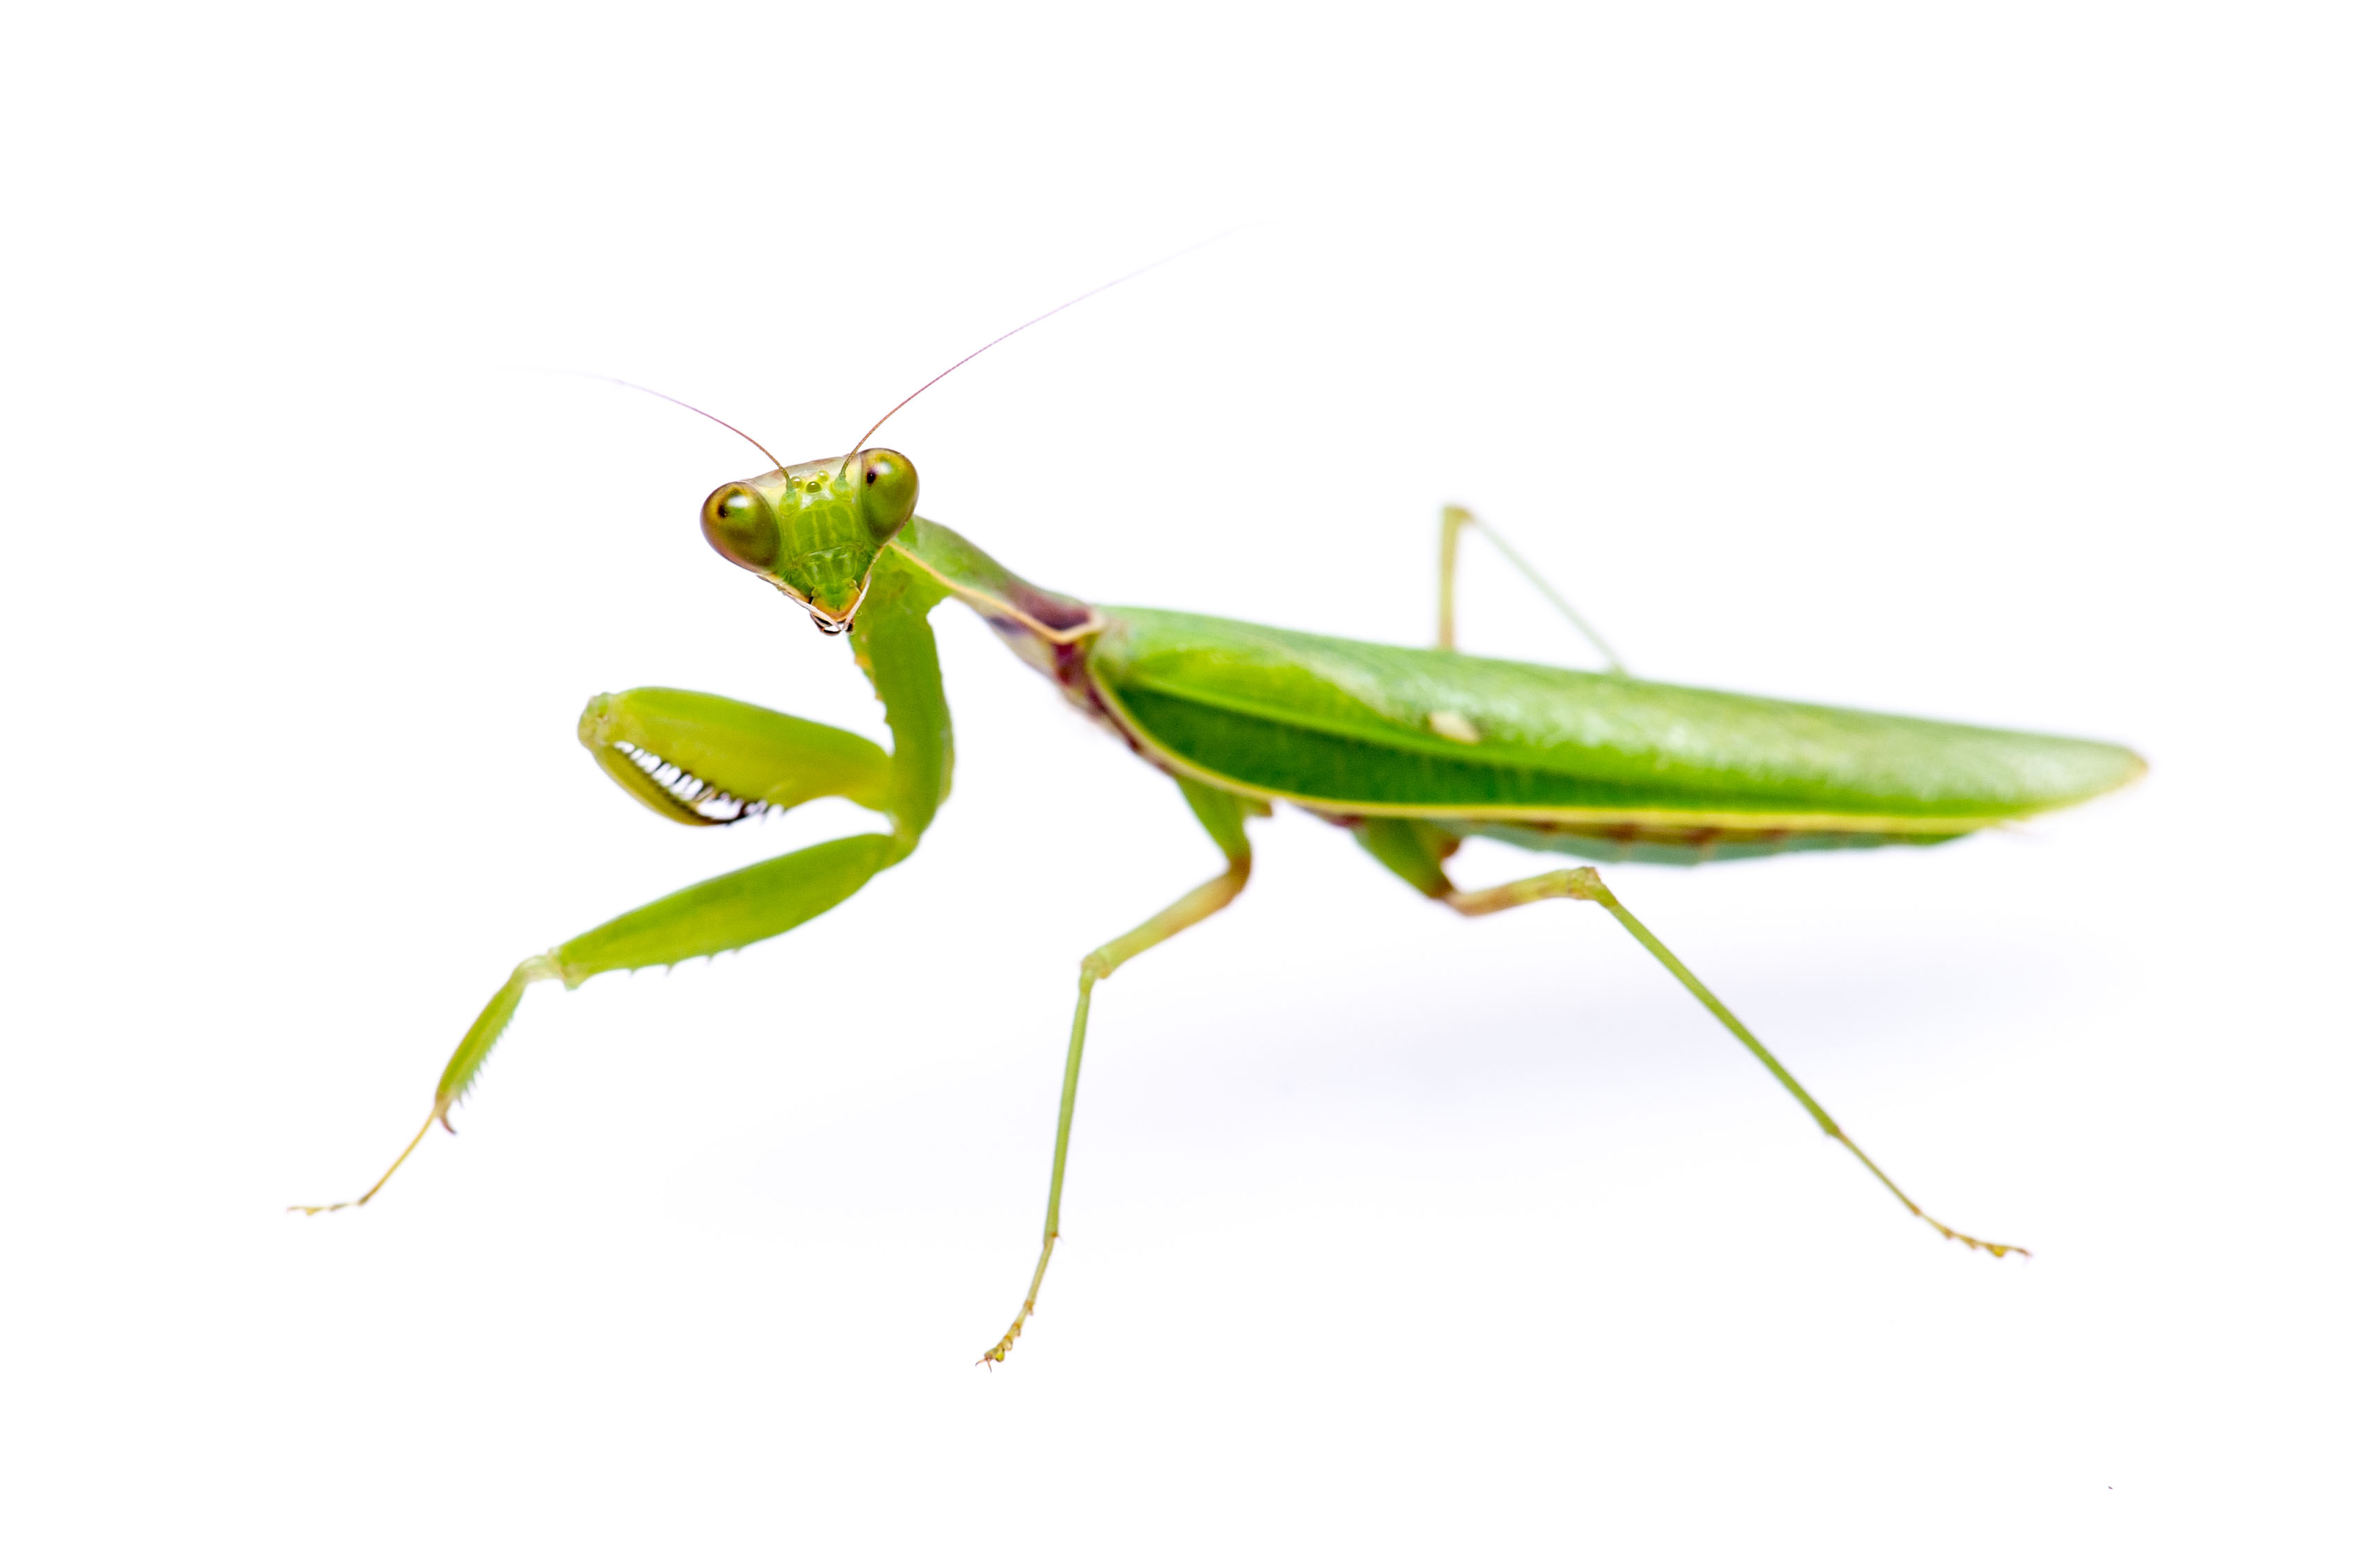

In [1]:
from IPython.display import display, Image #画像表示
import numpy as np
import cv2
from sklearn.cluster import KMeans
from ipywidgets import interact
import matplotlib.pyplot as plt
%matplotlib inline

PATH_IMG_IN=r"kama.jpg" #解析元ファイル名
SIZE_IMG=(150,-1)#画像サイズ -1でアスペクト比に合わせて大きさ自動決定
COLOR_OUTLINE=np.array([15,15,15,255],dtype=np.uint8) #輪郭線の色
NUMBER_PALETTE=16 #色数

def imgShow(img,format='.png',size=1):
    if size!=1:
        h,w=img.shape[:2]
        img=cv2.resize(img, (w*size, h*size),interpolation=cv2.INTER_NEAREST)
    decoded_bytes = cv2.imencode(format, img)[1].tobytes()
    display(Image(data=decoded_bytes))

img_original = cv2.imread(PATH_IMG_IN, -1)
imgShow(img_original)

In [2]:
#アルファ値非対応データ
if img_original.shape[-1]==3:
    h,w=img_original.shape[:2]
    def slideredGrabCutFunc(x0=0,y0=0,x1=w-1,y1=h-1):
        #背景削除
        mask=np.zeros((h,w),np.uint8)
        bgdModel = np.zeros((1,65),np.float64)
        fgdModel = np.zeros((1,65),np.float64)
        rect = (x0,y0,abs(x1-x0),abs(y1-y0))
        num_iteration=5
        cv2.grabCut(img_original,mask,rect,bgdModel,fgdModel,num_iteration,cv2.GC_INIT_WITH_RECT )
        global mask0
        mask0 = np.where((mask==2)|(mask==0),0,1)
        img_tmp=img_original.copy()
        img_tmp[mask0==0]*=0 #背景クロに

        #画像に描画
        cv2.rectangle(img_tmp, (x0,y0), (x1,y1), (0, 255, 0), thickness=1)
        imgShow(img_tmp)
    interact(slideredGrabCutFunc, x0=(0,w-1,1),y0=(0,h-1,1),x1=(0,w-1,1), y1=(0,h-1,1))
    img=np.zeros((h,w,4),dtype=np.uint8)
    img[:,:,:3]=img_original
    img[:,:,3]=(mask0==1)*255
else:
    img=img_original

interactive(children=(IntSlider(value=0, description='x0', max=3400), IntSlider(value=0, description='y0', max…

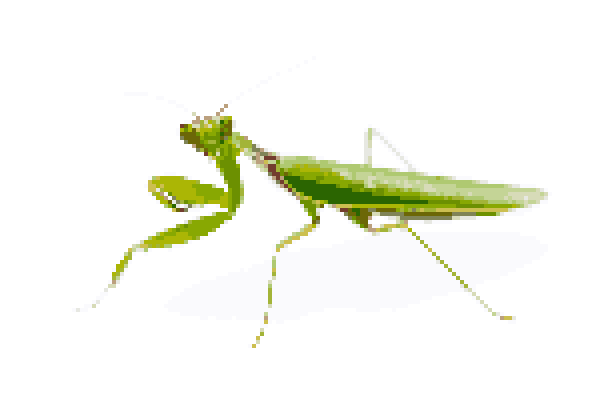

In [3]:
#縮小
if SIZE_IMG[0]<0:
    size_img=( int(0.5+SIZE_IMG[1]*img.shape[1]/img.shape[0]),SIZE_IMG[1] )
elif SIZE_IMG[1]<0:
    size_img=( SIZE_IMG[0],int( 0.5+SIZE_IMG[0]*img.shape[0]/img.shape[1] ) )
else:
    size_img=SIZE_IMG
img_small = cv2.resize(img, dsize=size_img)

#透過二値変換
is_invisible=(img_small[:,:,3]<128)
img_small[is_invisible==True]=np.array([0,0,0,0],dtype=np.uint8)
img_small[:,:,3][is_invisible==False]=255

#カラーパレット削減
pred = KMeans(n_clusters=NUMBER_PALETTE-1).fit_predict(img_small[:,:,:3][is_invisible==False])
colors=np.zeros((NUMBER_PALETTE-1,4))
for i in range(NUMBER_PALETTE-1):
    if len(img_small[is_invisible==False][pred==i])>0:
        colors[i]=np.average(img_small[is_invisible==False][pred==i],axis=0)
    else:
        colors[i]=np.array([0,0,0,0])
img_palette=img_small.copy()
img_palette[is_invisible==False]=np.array( [colors[i] for i in pred] ,dtype=np.uint8)
imgShow(img_palette,size=4)

In [4]:
#輪郭検出 & コントラスト
img_res=img_palette.copy()
def slideredFunc(contrast=1.0,offset=0.0,c_min=320,c_max=500,bool=True):
    # コントラスト
    img_tmp=(img_palette[:,:,:3].astype(int)-128)*contrast+128+offset
    img_tmp=(np.clip(img_tmp,0,255)+0.5).astype(np.uint8)
    # 輪郭
    img_canny_bgr=cv2.Canny(img_small[:,:,:3],c_min,c_max)
    img_canny_a=cv2.Canny(img_small[:,:,3],c_min,c_max)
    img_canny=(img_canny_bgr==255)+(img_canny_a==255)
    #表示
    img_res[:,:,:3]=img_tmp
    img_res[img_canny]=COLOR_OUTLINE
    imgShow(bool*img_res,size=4)
    print(c_max)
interact(slideredFunc, contrast=(1.,4.,0.1),offset=(-255,255,1),c_min=(0,1000,1), c_max=(0,1000, 1))

interactive(children=(FloatSlider(value=1.0, description='contrast', max=4.0, min=1.0), IntSlider(value=0, des…

<function __main__.slideredFunc(contrast=1.0, offset=0.0, c_min=320, c_max=500, bool=True)>

In [5]:
cv2.imwrite(PATH_IMG_IN+"_pixel.png",img_res)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U18'), dtype('<U18')) -> dtype('<U18')